In [53]:
import numpy as np
import matplotlib.pyplot as plt
import meanfi
from meanfi.model import Model
from meanfi.mf import density_matrix, meanfield
from meanfi.tb.tb import add_tb, _tb_type, scale_tb
from costcommutator import commutator, tb_to_matrix
from meanfi.params.rparams import tb_to_rparams, rparams_to_tb
from scipy.optimize import anderson, broyden1
from functools import partial

0:  |F(x)| = 0.363492; step 1
1:  |F(x)| = 0.364723; step 1
2:  |F(x)| = 0.11783; step 1
3:  |F(x)| = 0.0216689; step 1
4:  |F(x)| = 0.0228358; step 1
5:  |F(x)| = 0.00783153; step 1
6:  |F(x)| = 0.00487731; step 0.509579
7:  |F(x)| = 0.000364076; step 1
8:  |F(x)| = 5.69567e-06; step 1
9:  |F(x)| = 4.28788e-07; step 1
10:  |F(x)| = 1.94945e-09; step 1
11:  |F(x)| = 1.58434e-09; step 1
12:  |F(x)| = 1.98838e-09; step 1
13:  |F(x)| = 4.56907e-11; step 1


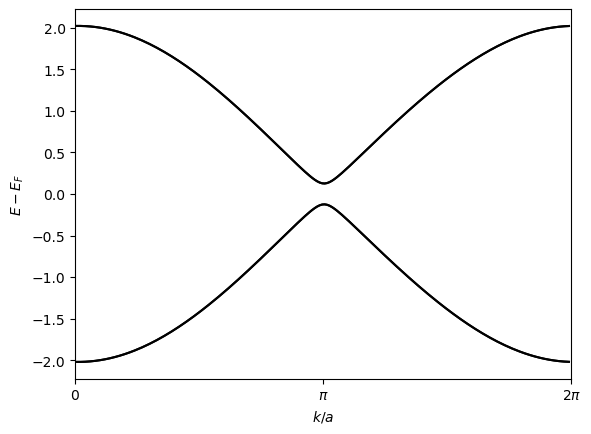

gap = -0.255019


In [55]:
def compute_comm(model: Model, nk: int, guess_keys, h_input: np.ndarray):
    h_tb = rparams_to_tb(h_input, list(guess_keys), ndof=full_model._ndof)
    rho, fermi_energy = density_matrix(h_tb, model.filling, nk)
    mf_correction = meanfield(rho, model.h_int)
    # h_mf = add_tb(add_tb(model.h_0, mf_correction),  {model._local_key: -fermi_energy * np.eye(model._ndof)})
    h_mf = add_tb(model.h_0, mf_correction)
    e = commutator(rho, h_mf)
    # guess_keys = h_mf.keys()
    return tb_to_rparams(e)

hopp = np.kron(np.array([[0, 1], [0, 0]]), np.eye(2))
h_0 = {(0,): hopp + hopp.T.conj(), (1,): hopp, (-1,): hopp.T.conj()}
U = 0
s_x = np.array([[0, 1], [1, 0]])
h_int = {
    (0,): U * np.kron(np.eye(2), s_x),
}
filling = 2
full_model = meanfi.Model(h_0, h_int, filling)
nk = 201

# guess = add_tb(full_model.h_0, meanfi.guess_tb(frozenset(full_model.h_int), ndof=full_model._ndof))
guess = full_model.h_0
guess_keys = guess.keys()
h_mf = rparams_to_tb(anderson(partial(compute_comm, full_model, nk, guess_keys), tb_to_rparams(guess), f_tol=1e-10, verbose=True, line_search='wolfe'), list(guess_keys), full_model._ndof)
hamiltonians = meanfi.tb_to_kgrid(h_mf, nk)
ks = np.linspace(0, 2 * np.pi, nk, endpoint=False)
vals, vecs = np.linalg.eigh(hamiltonians)
plt.plot(ks, vals, c="k")
plt.xticks([0, np.pi, 2 * np.pi], ["$0$", "$\\pi$", "$2\\pi$"])
plt.xlim(0, 2 * np.pi)
plt.ylabel("$E - E_F$")
plt.xlabel("$k / a$")
plt.show()
print('gap = %f' %(vals[100, 0]-vals[100, 2]))